# Predicting Uber Fare Prices
## Mark Bowen & John Ruscito & Peyton Theil

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns

### Import data and Inspect the Data

In [2]:
uber_data = pd.read_csv("uber.csv")
print("Shape of the Data: ", uber_data.shape)
uber_data.head()

Shape of the Data:  (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
print("Check for null values:\n", uber_data.isnull().sum())
uber_data = uber_data.dropna()
print("Null values after dropping:\n", uber_data.isnull().sum())


Check for null values:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64
Null values after dropping:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


## Data

### Feature Engineer pickup_datetime

In [4]:
uber_data.pickup_datetime = pd.to_datetime(uber_data.pickup_datetime, format = '%Y-%m-%d %H:%M:%S UTC', errors='coerce')

In [5]:
uber_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
(uber_data.pickup_datetime == "NaT").sum()

0

Extract extra information from pickup_datetime. <br>
Year is not important since it will never repeat (i.e. it will never be 2019 again)

In [7]:
uber_data['pickup_month'] = uber_data.pickup_datetime.dt.month
uber_data['pickup_week'] = uber_data.pickup_datetime.dt.isocalendar().week
uber_data['pickup_day'] = uber_data.pickup_datetime.dt.day
uber_data['pickup_hour'] = uber_data.pickup_datetime.dt.hour
uber_data['pickup_minute'] = uber_data.pickup_datetime.dt.minute
uber_data['pickup_dayofweek'] = uber_data.pickup_datetime.dt.dayofweek
uber_data[['pickup_month', 'pickup_week', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_dayofweek']].head()

,pickup_month,pickup_week,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek
0,5,19,7,19,52,3
1,7,29,17,20,4,4
2,8,35,24,21,45,0
3,6,26,26,8,22,4
4,8,35,28,17,47,3


Now that we have extracted the useful information out of pickup_datetime, we can remove the column from the data

Let's also drop key and id since they are not necessary for learning

In [8]:
uber_data = uber_data.drop(columns = ['pickup_datetime', 'key', 'Unnamed: 0'])
uber_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_month,pickup_week,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,5,19,7,19,52,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,7,29,17,20,4,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,8,35,24,21,45,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,6,26,26,8,22,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,8,35,28,17,47,3


Inspect Target Variable

Max fare: 499.0 || Min Fare: -52.0
Percentiles of fare: [ 3.7   6.    8.5  12.5  43.33]


<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

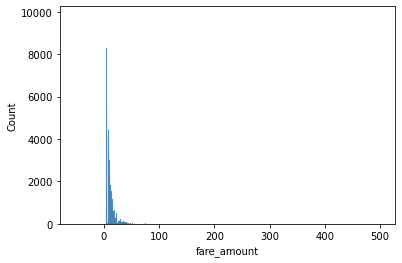

In [9]:
print("Max fare: {} || Min Fare: {}".format(max(uber_data.fare_amount), min(uber_data.fare_amount)))
print("Percentiles of fare: {}".format(np.percentile(uber_data.fare_amount, q = [2.5, 25, 50, 75, 97.5])))
sns.histplot(uber_data.fare_amount)

From looking at the min, max, and histogram together, we can see that there are outliers. We should drop all rows that have fare_amount under 0 because this is unrealistic. We should also drop values that are above the 95 percentile.

In [10]:
uber_data = uber_data[uber_data.fare_amount > 0]
uber_data = uber_data[uber_data.fare_amount <= np.percentile(uber_data.fare_amount, q = 95)]

# check percentiles to make sure correct drops were performed
print("Min Fare: {} || Max Fare: {}".format(min(uber_data.fare_amount), max(uber_data.fare_amount)))

Min Fare: 0.01 || Max Fare: 30.33


Now let's take another look at the histogram of fare_amount to get an idea of the distribution

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

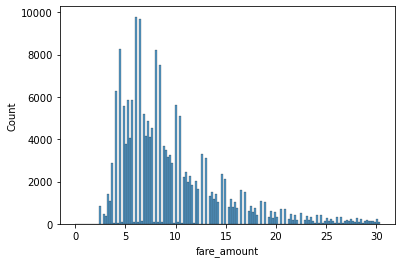

In [11]:
sns.histplot(uber_data.fare_amount)

Let's make sure latitude and longitude are actually possible values (-90 < lat < 90 and -180 < long < 180)

In [12]:
uber_data = uber_data[uber_data.pickup_latitude <= 90]
uber_data = uber_data[uber_data.pickup_latitude >= -90]
uber_data = uber_data[uber_data.pickup_longitude <= 180]
uber_data = uber_data[uber_data.pickup_longitude >= -180]
uber_data = uber_data[uber_data.dropoff_latitude <= 90]
uber_data = uber_data[uber_data.dropoff_latitude >= -90]
uber_data = uber_data[uber_data.dropoff_longitude <= 180]
uber_data = uber_data[uber_data.pickup_longitude >= -180]

### Create X (all features) and Y (fare_amount)

In [13]:
Y = uber_data.fare_amount
X = uber_data.drop(columns='fare_amount')
print("X shape: {} \nY shape: {}".format(X.shape, Y.shape))

X shape: (189989, 11) 
Y shape: (189989,)


### Split Data into Training sets and Testing sets

In [14]:
Xtr, Xte, Ytr, Yte = ms.train_test_split(X, Y) # shuffle is true by default & test_size is .25 by default
print("Xtr shape: {} \nXte shape: {} \nYtr shape: {}\nYte shape: {}".format(Xtr.shape, Xte.shape, Ytr.shape, Yte.shape))

Xtr shape: (142491, 11) 
Xte shape: (47498, 11) 
Ytr shape: (142491,)
Yte shape: (47498,)


## Search for the best preprocessing techniques

### Here we implement our own grid search that is quite computationally expensive but allows us to try more complex combinations than sklearn's implementation

In [15]:
model_grid = {
    "Ridge Alpha = .1 ": lm.Ridge(alpha = .1), 
    "Ridge Alpha = .01 ": lm.Ridge(alpha = .01),
    "Ridge Alpha = .001 ": lm.Ridge(alpha = .001),
    # "Ridge Alpha = .0001: ": lm.Ridge(alpha = .0001) Was never chosen as best parameter so it will be omitted
    }
scaler_grid = {
    'MinMax': pp.MinMaxScaler(), 
    'Robust': pp.RobustScaler(), 
    'Standard': pp.StandardScaler()
    }
transformer_grid = {
    'Quantile': pp.QuantileTransformer(),
    # 'Power': pp.PowerTransformer() // We dont apply this anymore since all tests before gave negative results and it slows runtime down drastically
    }
poly_feats_grid = {
    "pf = 1": pp.PolynomialFeatures(degree = 1),
    "pf = 2": pp.PolynomialFeatures(degree = 2),
    "pf = 3": pp.PolynomialFeatures(degree = 3),
    "pf = 4": pp.PolynomialFeatures(degree = 4)
    }

In [16]:
# Create Dictionary to track scores
scores = {}

# Compute base model (Normal Linear Regression since alpha = 0)
base_model = lm.Ridge()
base_model.fit(Xtr, Ytr)
base_y_preds = base_model.predict(Xte)
error = mean_squared_error(base_y_preds, Yte, squared = False)
print("No Transformations: {}".format(error))
scores["No Transformations"] = error
best_score = error
best_model_name = "base_model"
best_model = None
best_scaler_name = "None"
best_scaler = None
best_transformer_name = "None"
best_transformer = None


# Set up nested for loops (This is what makes it so computationally expensive)
for h, (model_name, model) in enumerate(model_grid.items()):
    for i, (scaler_name, scaler) in enumerate(scaler_grid.items()):
        for j, (transformer_name, transformer) in enumerate(transformer_grid.items()):
            for k, (pf_degree, poly_feats) in enumerate(poly_feats_grid.items()):

                # Create the pipeline with all the different possible preprocessing combinations
                pipe = pipeline.make_pipeline(scaler, transformer, poly_feats, model)
                
                # Cross validate the combination (Also what makes it compuationally expensive)
                cv_scores = ms.cross_validate(pipe.fit(Xtr, Ytr), Xtr, Ytr, scoring='neg_root_mean_squared_error')

                # Create combination string to be used as a key in dictionary storing scores
                combination = model_name + ", " + scaler_name + ", " + transformer_name + ", " + pf_degree

                # Calcuate average score of folds
                score = -1 * (sum(cv_scores['test_score']) / len(cv_scores['test_score']))

                # Store score in dictionary
                scores[combination] = score

                # If the score is lower than the previous best: Keep track of parameters
                if score < best_score: 
                    best_score = score
                    best_model_name = model_name
                    best_model = model
                    best_scaler_name = scaler_name
                    best_scaler = scaler
                    best_transformer_name = transformer_name
                    best_transformer = transformer
                    best_pf_degree = pf_degree
                    best_pf = poly_feats
                    best_pipe = pipe
                    best_cv_stats = cv_scores
                    print("\nNew Best: {}, {}, {}, {}\nScore: {}".format(model_name, scaler_name, transformer_name, pf_degree, score))

print("\nBest Combination:\nBest Alpha: {}\nBest Scaler: {}\nBest Transformer: {}\nBest PolyFeat Degree: {}\nBest Score: {}".format(best_model_name, best_scaler_name, best_transformer_name, best_pf_degree, best_score))


No Transformations: 5.1989130563912305

New Best: Ridge Alpha = .1 , MinMax, Quantile, pf = 1
Score: 5.126699063781796

New Best: Ridge Alpha = .1 , MinMax, Quantile, pf = 2
Score: 3.7324924951135734

New Best: Ridge Alpha = .1 , MinMax, Quantile, pf = 3
Score: 3.6226591179700796

New Best: Ridge Alpha = .1 , MinMax, Quantile, pf = 4
Score: 3.2105974712027794

New Best: Ridge Alpha = .1 , Robust, Quantile, pf = 4
Score: 3.2103665831404293

New Best: Ridge Alpha = .1 , Standard, Quantile, pf = 4
Score: 3.2103312020103183

New Best: Ridge Alpha = .01 , MinMax, Quantile, pf = 4
Score: 3.1791739627947004

New Best: Ridge Alpha = .01 , Standard, Quantile, pf = 4
Score: 3.1788830014912106

Best Combination:
Best Alpha: Ridge Alpha = .01 
Best Scaler: Standard
Best Transformer: Quantile
Best PolyFeat Degree: pf = 4
Best Score: 3.1788830014912106


## Here is the Best Combination of preprocessing techniques

In [17]:
best_pipe.named_steps

{'standardscaler': StandardScaler(),
 'quantiletransformer': QuantileTransformer(),
 'polynomialfeatures': PolynomialFeatures(degree=4),
 'ridge': Ridge(alpha=0.01)}

## Time to put the best model up against the Test Set

In [18]:
best_pipe.fit(Xtr, Ytr)
y_preds = best_pipe.predict(Xte)
rmse = mean_squared_error(Yte, y_preds, squared = False)
print("Test Error: {}".format(rmse))

Test Error: 3.201246935723408


## Plot 50 Predictions against Actual Values

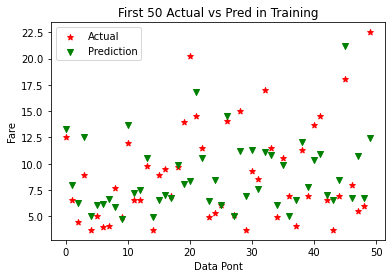

In [19]:
plt.title("First 50 Actual vs Pred in Training")
plt.ylabel("Fare")
plt.xlabel("Data Pont")
plt.scatter(np.arange(0, 50), Yte[:50], color='r', label = "Actual", marker = '*')
plt.scatter(np.arange(0, 50), y_preds[:50], color = 'g', label = "Prediction", marker = 'v')
plt.legend()